### Data Import and Cleaning

In [72]:
# Imports
import psycopg2
import pandas as pd
import numpy as np
import warnings

# Supress warnings
warnings.filterwarnings("ignore")

# Database config for postgres (from config.py)
from config import DATABASE 

In [73]:
# Pull the data from my postgre SQL database from project 3
# Currently only pulling from one tournament format to simplify the model
# Store it as a dataframe

sql_query = """
SELECT
    E."EventDate",
    C."CardID",
    C."Name",
    COALESCE(SUM(MD."Copies"), 0) AS "MaindeckCopies",
    COALESCE(SUM(SB."Copies"), 0) AS "SideboardCopies",
    COALESCE(SUM(MD."Copies"), 0) + COALESCE(SUM(SB."Copies"), 0) AS "TotalCopies",
    P."Price" AS "PriceOnEventDay"
FROM
    "Events" E
CROSS JOIN
    "Cards" C
LEFT JOIN
    "Maindeck" MD ON E."EventID" = MD."EventID" AND C."CardID" = MD."CardID"
LEFT JOIN
    "Sideboard" SB ON E."EventID" = SB."EventID" AND C."CardID" = SB."CardID"
LEFT JOIN
    "Prices" P ON C."CardID" = P."CardID" AND E."EventDate" = P."Date"
WHERE
    E."Format" = 'Modern'
GROUP BY
    E."EventDate",
    C."CardID",
    C."Name",
    P."Price"
ORDER BY
    E."EventDate",
    C."CardID";
"""

try:
    # Connect to the database
    conn = psycopg2.connect(**DATABASE)
    
    # Execute the query and load the result into a Pandas DataFrame
    df = pd.read_sql_query(sql_query, conn)
    
    # close the connection
    conn.close()

except Exception as e:
    print(f"An error occurred: {e}")

# Preview the resulting dataframe
df.head()


,EventDate,CardID,Name,MaindeckCopies,SideboardCopies,TotalCopies,PriceOnEventDay
0,2024-01-01,1,Aether Spellbomb,0,0,0,0.002
1,2024-01-01,2,Aether Vial,4,0,4,2.760
2,2024-01-01,3,Aluren,0,0,0,0.340
3,2024-01-01,4,Ancient Tomb,0,0,0,15.990
4,2024-01-01,5,Animate Dead,0,0,0,0.020


In [74]:
# Check dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62343 entries, 0 to 62342
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EventDate        62343 non-null  object 
 1   CardID           62343 non-null  int64  
 2   Name             62343 non-null  object 
 3   MaindeckCopies   62343 non-null  int64  
 4   SideboardCopies  62343 non-null  int64  
 5   TotalCopies      62343 non-null  int64  
 6   PriceOnEventDay  62087 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 3.3+ MB


In [75]:
# Clean the dataframe

# Replace empty strings with NaN
df.replace('', np.nan, inplace=True)

# Drop rows that have any NaN values (now including originally blank cells)
df.dropna(how='any', inplace=True)

# Update relevant dtypes
df['EventDate'] = pd.to_datetime(df['EventDate'])
df['CardID'] = df['CardID'].astype(int)

# Drop now unnecessary columns
df = df.drop(['MaindeckCopies', 'SideboardCopies'], axis=1)

# Only keep cards in the table that are commonly played (we'll use >100 copies total in the month)
# Optimization note: This number was modified throughout to see if it affected accuracy 
df = df.groupby('CardID').filter(lambda x: x['TotalCopies'].sum() >= 100)

# Only keep cards worth more than a dollar (to make it worth our time to invest!)
# Optimization note: This number was modified throughout to see if it affected accuracy 
df = df.groupby('CardID').filter(lambda x: x['PriceOnEventDay'].mean() >= 1)

# Display the first few rows to verify changes
df.head()


,EventDate,CardID,Name,TotalCopies,PriceOnEventDay
13,2024-01-01,14,Bloodstained Mire,15,4.03
15,2024-01-01,16,"Boseiju, Who Endures",24,16.95
22,2024-01-01,23,Chalice of the Void,21,8.72
27,2024-01-01,28,Crashing Footfalls,8,3.56
34,2024-01-01,35,Dragon's Rage Channeler,8,1.85


### Theory

My hypthoesis is that for any specific card, two events in a row running of higher than the previous week's average number of copies triggers a buy signal if the price does not show a similar flucuation. I should be able to create a price prediction model based on tournament usage to check for buy targets.

### Modeling - Test Case

In [116]:
# Imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [126]:
# Choose a specific card (in this case Boseiju, Who Endures) as a test
card_df = df[df['CardID'] == 16].copy().set_index('EventDate')
card_df

,CardID,Name,TotalCopies,PriceOnEventDay
EventDate,,,,
2024-01-01,16,"Boseiju, Who Endures",24,16.95
2024-01-02,16,"Boseiju, Who Endures",0,16.45
2024-01-03,16,"Boseiju, Who Endures",0,17.03
2024-01-04,16,"Boseiju, Who Endures",0,17.59
2024-01-05,16,"Boseiju, Who Endures",20,17.91
2024-01-06,16,"Boseiju, Who Endures",26,19.24
2024-01-07,16,"Boseiju, Who Endures",20,19.24
2024-01-08,16,"Boseiju, Who Endures",26,17.66
2024-01-09,16,"Boseiju, Who Endures",33,17.37


            Actual  Predicted
2024-01-25   14.35  15.429415
2024-01-26   15.45  15.742991
2024-01-27   15.45  15.965881
Accuracy: 95.74750873760763%
Buy Target: True


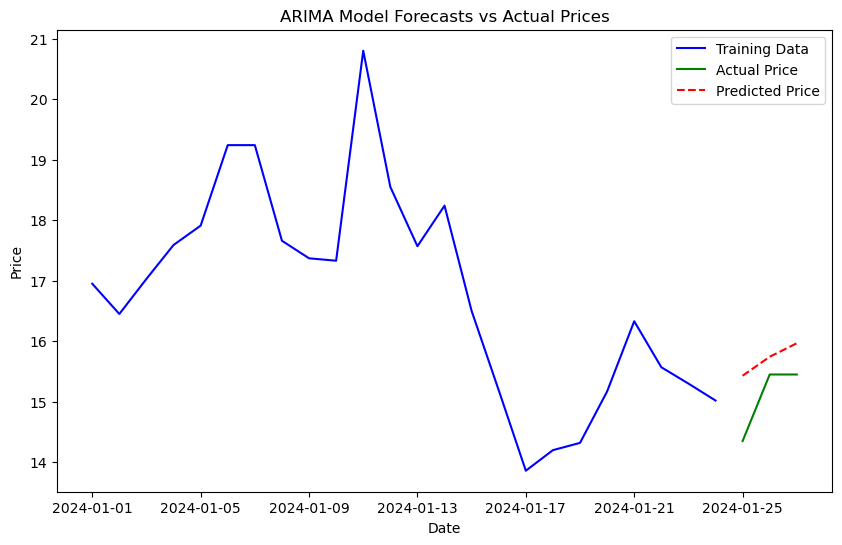

In [127]:
# Set frequency
card_df.index.freq = 'D'

# Splitting the dataset into train and test sets
split_point = int(len(card_df) * 0.9)
train, test = card_df.iloc[:split_point,:], card_df.iloc[split_point:, :]

# Fit an ARIMA model
# Optimization note: Many different orders were tried. see auto_arima codeblock below.
model = ARIMA(endog=train['PriceOnEventDay'], exog=train[['TotalCopies']], order=(1, 0, 0))
model_fit = model.fit()

# Forecast using the model, including the exogenous variable for the test set
predictions = model_fit.forecast(steps=len(test), exog=test[['TotalCopies']])

# Compare the predictions with the actual values
compare_df = pd.DataFrame({'Actual': test['PriceOnEventDay'], 'Predicted': predictions})
print(compare_df)

# Accuracy summary
mape = 100 - (np.mean(np.abs((compare_df['Actual'] - compare_df['Predicted']) / compare_df['Actual'])) * 100)
print(f'Accuracy: {mape}%')

# Flag if buy target
buy_target = max(compare_df['Predicted']) > card_df.iloc[-1]['PriceOnEventDay']
print(f'Buy Target: {buy_target}')

# Plotting the forecast alongside actual values
# Setting up the plot
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train['PriceOnEventDay'], label='Training Data', color='blue')

# Plot actual prices from test set
plt.plot(test.index, test['PriceOnEventDay'], label='Actual Price', color='green')

# Plot predicted prices
plt.plot(test.index, predictions, label='Predicted Price', color='red', linestyle='--')

# Adding plot title and labels
plt.title('ARIMA Model Forecasts vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Display the plot
plt.show()

Buy Target: True


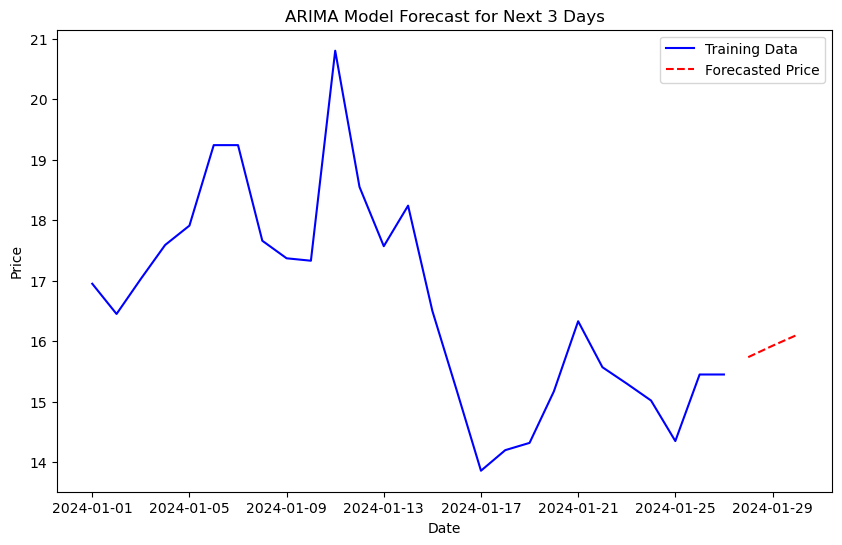

In [130]:
# Predicting three days beyond the dataset

# Set frequency
card_df.index.freq = 'D'

# Since you're using the entire dataset for training, there's no need to split
train = card_df

# Fit an ARIMA model to the entire dataset
model = ARIMA(endog=train['PriceOnEventDay'], exog=train[['TotalCopies']], order=(1, 0, 0))
model_fit = model.fit()

# Prepare exogenous variables for the next 3 days
next_3_days_total_copies = [[35], [30], [40]]

# Forecast using the model for the next 3 days
predictions = model_fit.forecast(steps=3, exog=next_3_days_total_copies)

# Flag if buy target
buy_target = max(compare_df['Predicted']) > card_df.iloc[-1]['PriceOnEventDay']
print(f'Buy Target: {buy_target}')

# Setting up the plot
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train['PriceOnEventDay'], label='Training Data', color='blue')

# Generation of forecast dates
last_date = train.index[-1]
start_date = last_date + pd.Timedelta(days=1)  # Start from the next day after the last date in the training set
forecast_dates = pd.date_range(start=start_date, periods=3)  # Now correctly generates the next 3 days

# Plot predicted prices for the next 3 days
plt.plot(forecast_dates, predictions, label='Forecasted Price', color='red', linestyle='--')

# Adding plot title and labels
plt.title('ARIMA Model Forecast for Next 3 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Display the plot
plt.show()



In [119]:
# Attempted to use a package to auto-determine the order variable for the model. This was not used in the final data output, 
# and was used more as a learning tool. 
from pmdarima import auto_arima

exog_data = card_df[['TotalCopies']]

model = auto_arima(card_df['PriceOnEventDay'],exogenous=exog_data, 
                   start_p=0, start_q=0,
                   max_p=5, max_q=5, max_d=2,  # Maximum p, q, and d values to test
                   seasonal=False,  # Set to True if your data is seasonal
                   trace=True,  # Prints the fitting progress
                   error_action='ignore',  # Don't want to know if an order does not work
                   suppress_warnings=True,  # Suppress convergence warnings
                   stepwise=True)  # Use the stepwise algorithm to select the model

# Print the summary of the selected ARIMA model
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=152.194, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5.980, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4.741, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6.723, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6.677, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4.711, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=6.683, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=84.305, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=7.887, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2.996, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-4.995, Time=0.04 sec
 ARIMA(0,0,1)(0

### Apply the Model to the Entire Dataset

In [120]:
cards = df['CardID'].unique()
outcomes = []

for card in cards:
    card_df = df[df['CardID'] == card].copy().set_index('EventDate')
    # Set frequency
    card_df.index.freq = 'D'

    # Splitting the dataset into train and test sets
    split_point = int(len(card_df) * 0.9)
    train, test = card_df.iloc[:split_point,:], card_df.iloc[split_point:, :]

    # Fit an ARIMA model
    # Optimization note: Many different orders were tried
    model = ARIMA(endog=train['PriceOnEventDay'], exog=train[['TotalCopies']], order=(1, 0, 0))
    model_fit = model.fit()

    # Forecast using the model, including the exogenous variable for the test set
    predictions = model_fit.forecast(steps=len(test), exog=test[['TotalCopies']])

    # Compare the predictions with the actual values
    compare_df = pd.DataFrame({'Actual': test['PriceOnEventDay'], 'Predicted': predictions})

    # Accuracy summary
    mape = 100 - (np.mean(np.abs((compare_df['Actual'] - compare_df['Predicted']) / compare_df['Actual'])) * 100)

    # Flag if buy target
    # That is, if the max predicted price is higher than the final measured price, return True
    buy_target = max(compare_df['Predicted']) > card_df.iloc[-1]['PriceOnEventDay']

    #Build the outcomes dataframe
    name = df[df['CardID'] == card]['Name'].iloc[1]
    copies = df[df['CardID'] == card]['TotalCopies'].sum()
    avg_price = df[df['CardID'] == card]['PriceOnEventDay'].mean()
    last_price = card_df.iloc[-1]['PriceOnEventDay']
    outcomes.append({'CardID': card, 'Name': name, 'TotalCopies': copies, 'AveragePrice': avg_price, 'LastPrice':last_price, 'ModelAccuracy': mape, 'BuyTarget': buy_target})

In [121]:
# Look at the final outcomes
outcomes_df = pd.DataFrame(outcomes)
outcomes_df.head()


,CardID,Name,TotalCopies,AveragePrice,LastPrice,ModelAccuracy,BuyTarget
0,14,Bloodstained Mire,365,3.900370,3.90,98.348457,True
1,16,"Boseiju, Who Endures",511,16.616296,15.45,95.747509,True
2,23,Chalice of the Void,593,9.831111,11.15,91.702015,False
3,28,Crashing Footfalls,226,3.695185,4.01,89.590454,False
4,35,Dragon's Rage Channeler,263,1.736296,1.41,95.682133,True


In [122]:
# Final Summary
print(f'Average Model Accuracy: {round(outcomes_df["ModelAccuracy"].mean(),2)}%')
print(f'Total Buy Targets: {len(outcomes_df[outcomes_df["BuyTarget"] == True])}')

Average Model Accuracy: 91.54%
Total Buy Targets: 32


In [123]:
# Export the buylist to csv for further analysis
buylist_df = outcomes_df[outcomes_df["BuyTarget"] == True]
buylist_df.to_csv('buylist.csv', index=False)
